### Import Packages

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, AutoModel
import torch
import torch.nn.functional as F
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import seaborn as sns
from pylab import rcParams
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Settings for plots + random_seed

Random_seed randomizes the train_test_split to ensure that the distribution of data samples remains relatively similar

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Import Dataset

For this project, I used a TripAdvisor dataset from Kaggle, which contains 20,000 reviews and their corresponding ratings from 1 to 5.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


I changed the 'Rating' column to be zero-based to make it easier to map to the predicted rating later on, which will be selected by index.

In [4]:
df = pd.read_csv(f'{path}/tripadvisor_hotel_reviews.csv')

#Move Rating to zero-based

df['Rating'] = df['Rating'].apply(lambda x: x - 1)

# print(df.dtypes)

print(df.head())

sorted(df.Rating.unique())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       3
1  ok nothing special charge diamond member hilto...       1
2  nice rooms not 4* experience hotel monaco seat...       2
3  unique, great stay, wonderful time hotel monac...       4
4  great stay great stay, went seahawk game aweso...       4


[0, 1, 2, 3, 4]

### Distribution of Ratings

The plot below shows the distribution of ratings of the 20,000 reviews. Almost half of the reviews appear to be 5-stars, and the majority of reviews are 4 to 5 stars.

[Text(0, 0, '1-Star'),
 Text(1, 0, '2-Star'),
 Text(2, 0, '3-Star'),
 Text(3, 0, '4-Star'),
 Text(4, 0, '5-Star')]

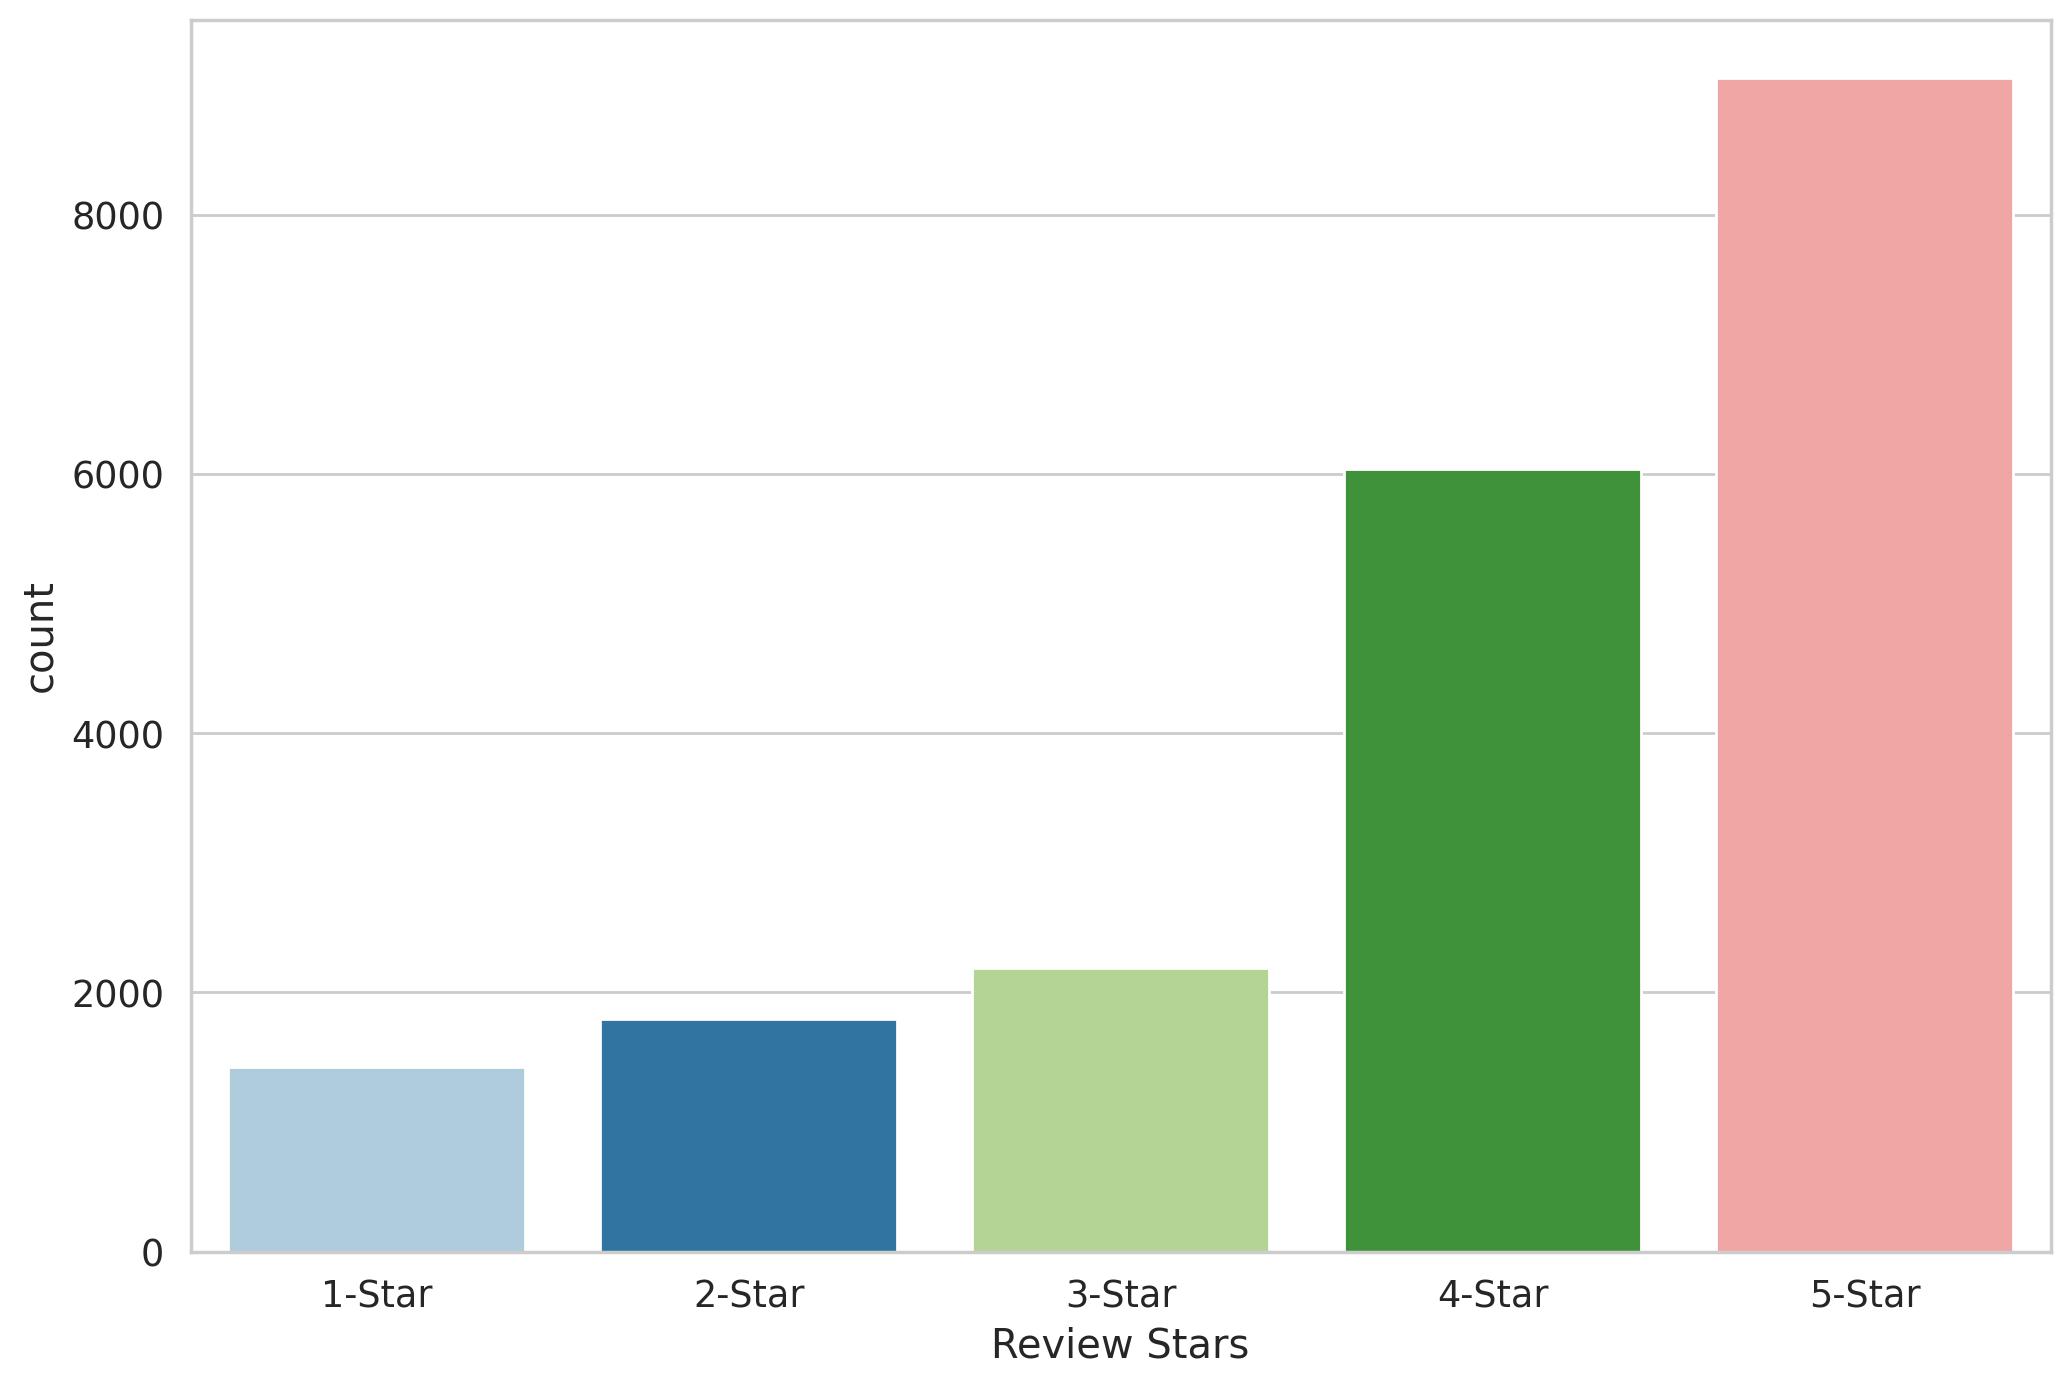

In [5]:
class_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star' ]

ax = sns.countplot(df, x='Rating')

plt.xlabel('Review Stars')

ax.set_xticklabels(class_names)

### Splitting the data

The dataset was split into 70% training, 15% validation and 15% test. This is because the dataset is neither small nor big, hence we can afford to have slightly more validation and test data for evaluation.

In [6]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(14343, 2) (3074, 2) (3074, 2)


### Preparing the dataset

The ReviewDataset class mirrors the DataSet class in Pytorch, which is loaded into the DataLoader. I modified the __len__ and __getitem__ functions to accomodate the review and targets columns based on the context of the problem at hand. __getitem__ is a function for DataLoader to return a sample from the dataset at given index.

Tokenization splits each sequence of text up into discrete units (words in our case), followed by encoding which converts the tokens into unique integers for processing as it is generally more computationally efficient for the model to work with numbers.

As BERT models can only process up to 512 characters, I extracted the first 512 characters of each review by setting the max_length during encoding.

Data Collator With Padding helps to create the batch and each set of input_ids will be padded.

In [7]:
max_length = 512
batch_size = 16

class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True,
            padding = 'longest',
            return_tensors = 'pt',)

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

        return output

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

def create_data_loader(df, tokenizer, max_len = max_length, batch_size = batch_size):
    dataset = ReviewDataset(
        reviews=df.Review.to_list(),
        targets = df.Rating.to_list(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collator)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer)
test_data_loader = create_data_loader(df_test, tokenizer)

### DataLoader check

In [9]:
#Testing to see if the data loader works appropriately
check_data = next(iter(train_data_loader))

print(check_data.keys()) # dict_keys(['input_ids', 'attention_mask', 'targets'])

print(check_data['input_ids'].shape) # torch.Size([16, 512])

print(check_data['attention_mask'].shape) # torch.Size([16, 512])

print(check_data['targets'].shape) # torch.Size([16])

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


### Modeling

I used a BERT model as the pre-trained model for this task as it is bi-directional, meaning it can consider the context of the entire sentence instead of only reading from left to right like other models. This is important for sentiment analysis as it can then understand context from both directions to better understand the overall meaning of the text.

torch.nn.Module is used to build the layers of the model. The SentimentAnalysis class inherits the torch.nn.Module class.

Dropout is used as a technique to prevent overfitting by 'turning off' a portion of the nodes randomly. This ratio was set to 0.3 after several rounds of trial and error.

Additionally, I froze all the layers of the base BERT model except the last layer to improve training efficiency and also to combat overfitting, Only the top-most layer's parameters of the BERT model can be tuned, while the other layers' parameters are fixed.

The out function using torch.nn.Linear linearises the input with the weights to produce the output tensor. The input shape is retrieved from the last layer's hidden_size.

We parse the input_ids and attention_masks to the model and extract the pooler_output. Pooler_output is a representation of each sequence in the batch. It takes the last hidden state of [CLS], the first token from each sequence. This contains a summary representation of the entire input sequence. This is then passed into a linear transformation as the classification head to produce the scores for each rating for a particular sequence.

In [10]:
class SentimentAnalysis(torch.nn.Module):

    def __init__(self, no_categories):
        super(SentimentAnalysis, self).__init__()
        self.bert = AutoModel.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment', return_dict=True)
        self.dropout = torch.nn.Dropout(p = 0.3)

        #args for Linear: (size of each input sample, size of each output sample)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, no_categories)

        #freeze layers

        modules = [self.bert.embeddings, *self.bert.encoder.layer[:11]]
        for m in modules:
            for name, params in m.named_parameters():
                params.requires_grad = False
                
        for m in self.bert.modules():
            for name, params in m.named_parameters():          
                print(name, params.requires_grad)

 
 
    def forward(self, input_ids, attention_mask):
        pooler_output = self.bert(
            input_ids = input_ids,
            attention_mask= attention_mask
        )['pooler_output']
        
        output = self.dropout(pooler_output)

        #perform linear transformation to output
        return self.out(output)

### Initializing the model

Here, we can see which layers has parameters that will be tuned (marked by True), and those that will not be tuned (marked by False).

In [11]:
model = SentimentAnalysis(len(class_names))
model = model.to(device)

# Evaluation run of the model
input_ids = check_data['input_ids'].to(device)
attention_mask = check_data['attention_mask'].to(device)

#print(attention_mask)


embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.token_type_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
encoder.layer.0.attention.self.query.weight False
encoder.layer.0.attention.self.query.bias False
encoder.layer.0.attention.self.key.weight False
encoder.layer.0.attention.self.key.bias False
encoder.layer.0.attention.self.value.weight False
encoder.layer.0.attention.self.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.attention.output.LayerNorm.weight False
encoder.layer.0.attention.output.LayerNorm.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.output.LayerNorm.weight False
encoder.layer.0.output.LayerNorm.bias False
encoder.layer.1.attention.self.query

Convert the output to probabilities using the softmax function

In [12]:
F.softmax(model(input_ids,attention_mask), dim = 1)

tensor([[0.2271, 0.1645, 0.2072, 0.1890, 0.2121],
        [0.2021, 0.1789, 0.2115, 0.1745, 0.2330],
        [0.1636, 0.1355, 0.2693, 0.2912, 0.1404],
        [0.2818, 0.2149, 0.1141, 0.1390, 0.2502],
        [0.2100, 0.2302, 0.1827, 0.1336, 0.2434],
        [0.2900, 0.1890, 0.1677, 0.1193, 0.2340],
        [0.2169, 0.1847, 0.2439, 0.2119, 0.1426],
        [0.2356, 0.1117, 0.2369, 0.2632, 0.1527],
        [0.2463, 0.1575, 0.1818, 0.1784, 0.2359],
        [0.2118, 0.1887, 0.2108, 0.2470, 0.1417],
        [0.2528, 0.1475, 0.2186, 0.1956, 0.1854],
        [0.2110, 0.1382, 0.2146, 0.2834, 0.1527],
        [0.2364, 0.2287, 0.1168, 0.1349, 0.2832],
        [0.1872, 0.2250, 0.1595, 0.1530, 0.2753],
        [0.2363, 0.1610, 0.2179, 0.2397, 0.1452],
        [0.2452, 0.1839, 0.1618, 0.1973, 0.2119]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Epochs was set at 5 to balance between fine-tuning and overfitting of the model to the training data.

AdamW optimizer will be used as it allows for faster convergence by adapting its learning rate and adding L2 regularization afterwards without the scaling.

Cross-entropy loss is used as loss function for multi-class classification.

In [13]:
epochs = 5

optimizer = optim.AdamW(model.parameters(), lr= 2e-5)
total_steps = len(train_data_loader) * epochs
loss_fn = nn.CrossEntropyLoss().to(device)


### Training the model

I used clip_grad_norm to keep gradients within a band, to prevent vanishing or exploding gradients.

loss.backward() computes dloss/dx for each parameter x which is summed up to x.grad. AdamW optimizer updates x using x.grad.

torch.max(outputs, dim=1) returns the maximum tensor values and the index of the maximum tensor value of each data point.

Note: Dropout + max norm regularization is shown to reduce error the greatest. Max norm regularization ensures that the L2 norm of weights do not cross a threshold by rescaling weights, in which the model doesn't over rely on large weights. Max norm is added using nn.utils.clip_grad_norm (On the other hand, L2 normalization adds penalty to cost function directly)

https://stats.stackexchange.com/questions/241001/deep-learning-use-l2-and-dropout-regularization-simultaneously

In [14]:
def train_model(model, data_loader, loss_fn, optimizer, device, train_size):

    model=model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.max(outputs, dim = 1).indices
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets).cpu()

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #Update the parameters using optimizer.step()
        optimizer.step()
        #Reset the gradients to zero for next batch
        optimizer.zero_grad()

    #return accuracy = correct_pred/train_size, train loss
    return correct_predictions/train_size, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, train_size):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            preds = torch.max(outputs, dim = 1).indices

            loss = loss_fn(outputs, targets.detach())
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())

    #return accuracy, validation loss
    return correct_predictions/train_size, np.mean(losses)

# Model Evaluation on test_data_loader
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    real_values = []

    #Disable obtaining gradients
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            preds = torch.max(outputs, dim=1).indices
            probs = F.softmax(outputs, dim =1)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

Check if cuda (GPU) is available for use

In [15]:
torch.cuda.is_available()

True

I trained the model for 5 epochs and saved the model weights giving the highest validation accuracy.

In [16]:
# %%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, epochs+1):
    print(f'Epoch {epoch}/{epochs}')
    print('----------------------------------------------------------------')
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, len(df_train))
    print(f'Training loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Validation loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/5
----------------------------------------------------------------
Training loss 0.8636454360075752 accuracy 0.6218364238739014
Validation loss 0.7785023339671792 accuracy 0.6620038747787476
Epoch 2/5
----------------------------------------------------------------
Training loss 0.7945226431889677 accuracy 0.6493062973022461
Validation loss 0.7649881022890614 accuracy 0.6623291969299316
Epoch 3/5
----------------------------------------------------------------
Training loss 0.7764496665734512 accuracy 0.653907835483551
Validation loss 0.7527879268085401 accuracy 0.6691607236862183
Epoch 4/5
----------------------------------------------------------------
Training loss 0.7600987979201569 accuracy 0.6663180589675903
Validation loss 0.7520737794705623 accuracy 0.6688354015350342
Epoch 5/5
----------------------------------------------------------------
Training loss 0.7468612302705196 accuracy 0.6701526641845703
Validation loss 0.749341047180749 accuracy 0.6688354015350342


### Results

From the classification report and confusion matrix, we can see that the accuracy of the model is 0.67. The model is noticeably much better at predicting 4-star and 5-star reviews than 1 to 3-star reviews. However, the 1-star reviews also perform better than the 2 and 3-star reviews. This could be because it is easier to predict extreme values more. Nonetheless, the confusion matrix shows that the overwhelming majority of predictions are correct or differ by 1 star.

              precision    recall  f1-score   support

      1-Star       0.80      0.59      0.68       231
      2-Star       0.47      0.62      0.53       272
      3-Star       0.53      0.37      0.44       347
      4-Star       0.62      0.57      0.59       930
      5-Star       0.76      0.85      0.80      1294

    accuracy                           0.67      3074
   macro avg       0.63      0.60      0.61      3074
weighted avg       0.67      0.67      0.66      3074



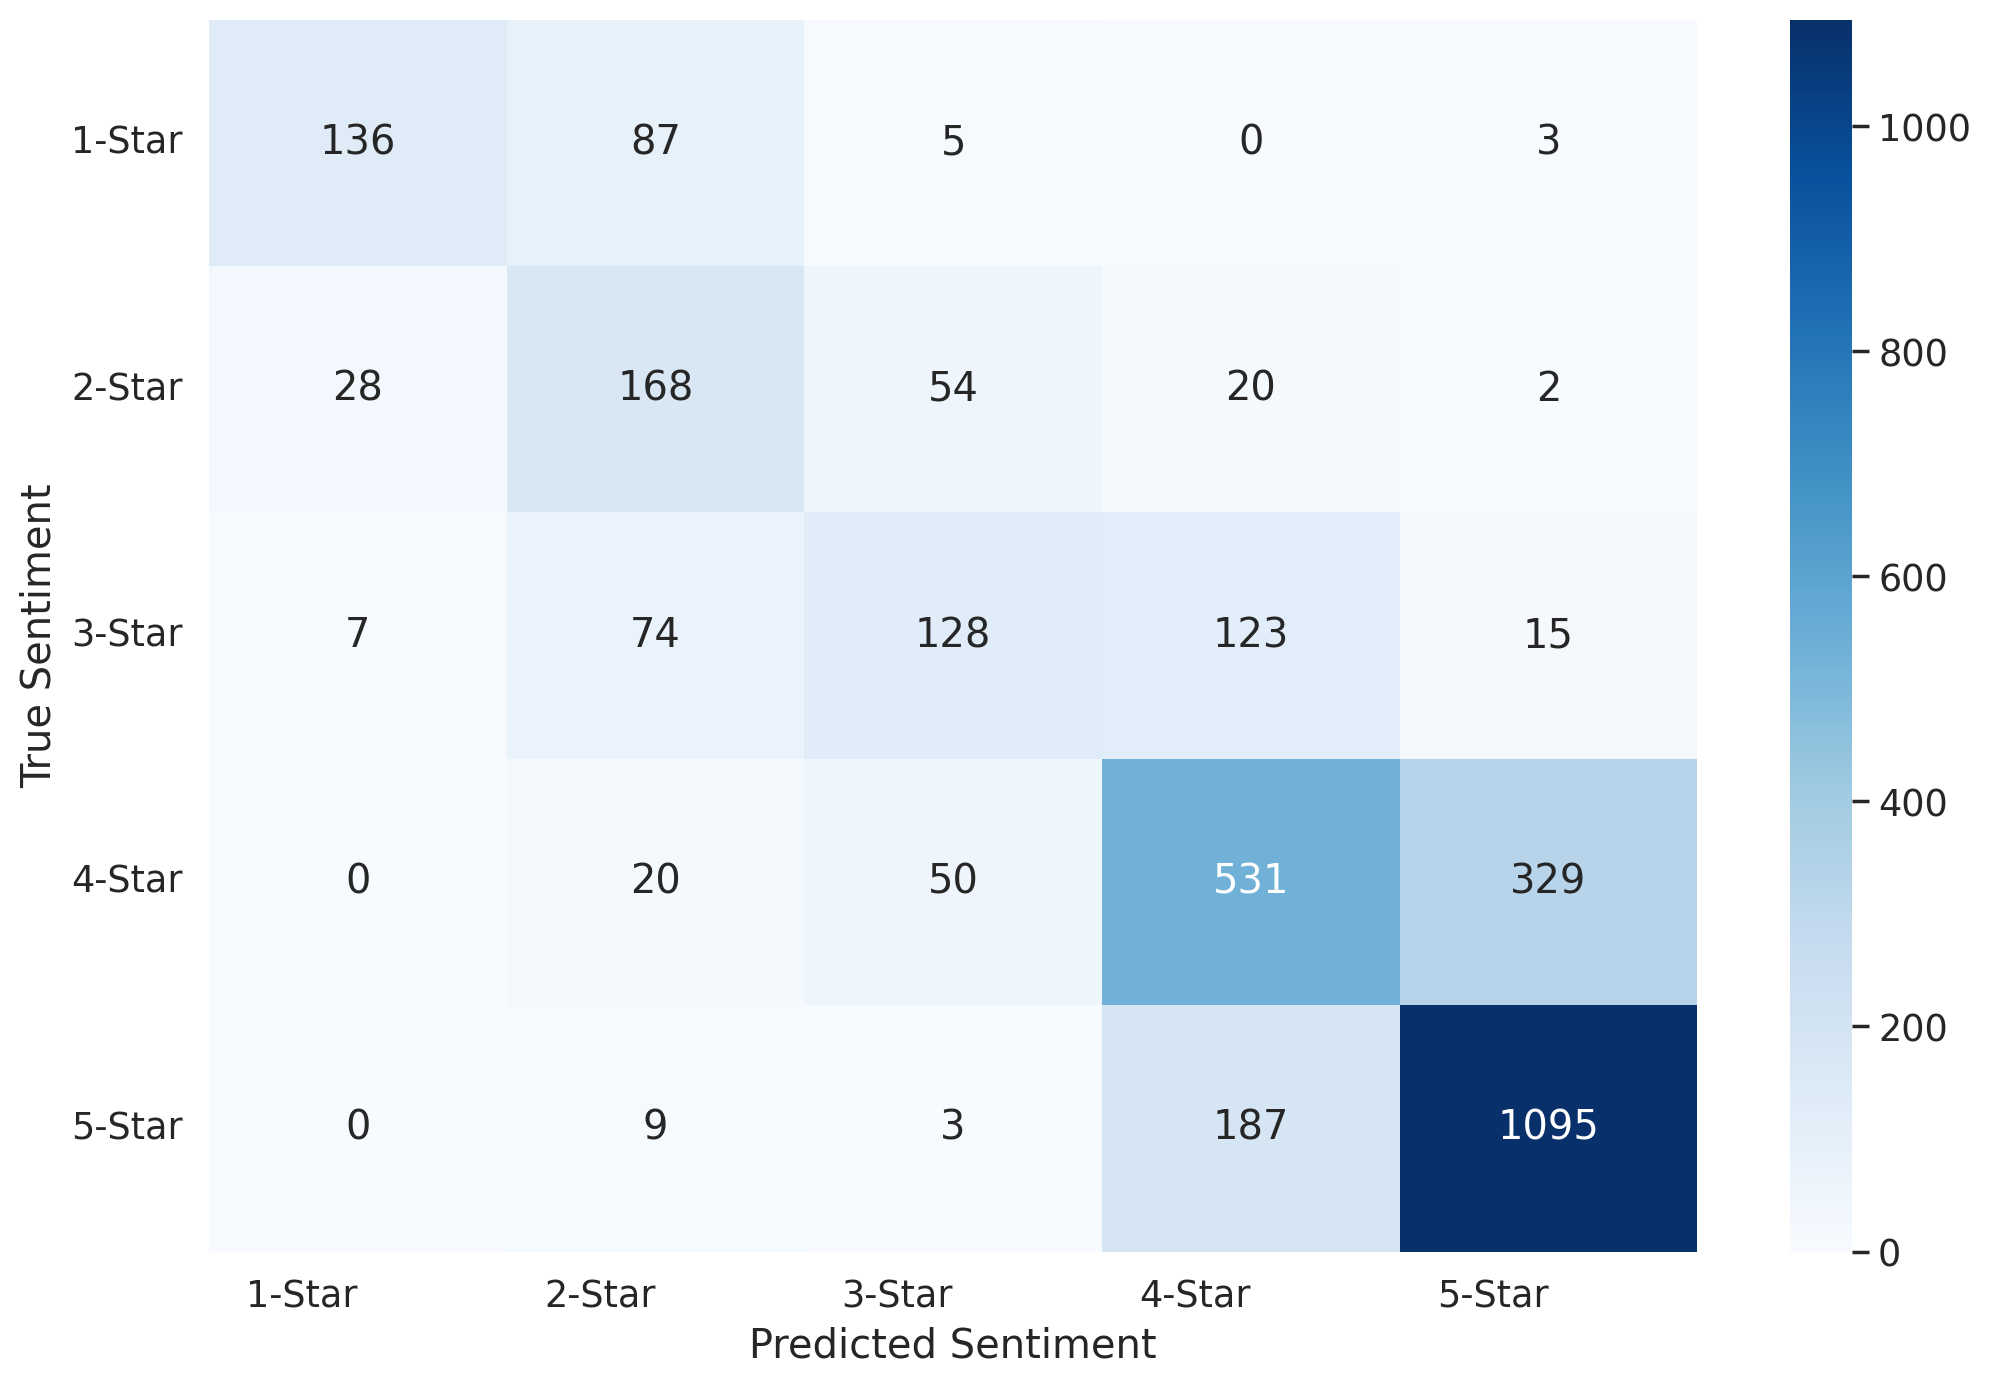

In [17]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 0, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

### Evaluate against original model without fine-tuning

The original model has a significantly lower overall accuracy at 0.53. It is better at predicting 1-star reviews accurately, but for 2 to 5-star reviews, the predictions are less accurate and more "spread out".

In [18]:
orig_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment', return_dict=True).to(device)

orig_model = orig_model.eval()
orig_predictions = []
orig_prediction_probs = []
orig_real_values = []

#Disable obtaining gradients
with torch.no_grad():
  for batch in test_data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["targets"].to(device)
      outputs = orig_model(input_ids = input_ids, attention_mask = attention_mask)['logits']
      probs = F.softmax(outputs, dim =1)
      preds = torch.max(outputs, dim=1).indices
      orig_predictions.extend(preds)
      orig_prediction_probs.extend(probs)
      orig_real_values.extend(targets)

orig_predictions = torch.stack(orig_predictions).cpu()
orig_prediction_probs = torch.stack(orig_prediction_probs).cpu()
orig_real_values = torch.stack(orig_real_values).cpu()

print(classification_report(orig_real_values, orig_predictions, target_names=class_names))

              precision    recall  f1-score   support

      1-Star       0.44      0.81      0.57       231
      2-Star       0.29      0.43      0.34       272
      3-Star       0.30      0.37      0.33       347
      4-Star       0.52      0.43      0.47       930
      5-Star       0.75      0.61      0.68      1294

    accuracy                           0.53      3074
   macro avg       0.46      0.53      0.48      3074
weighted avg       0.57      0.53      0.54      3074



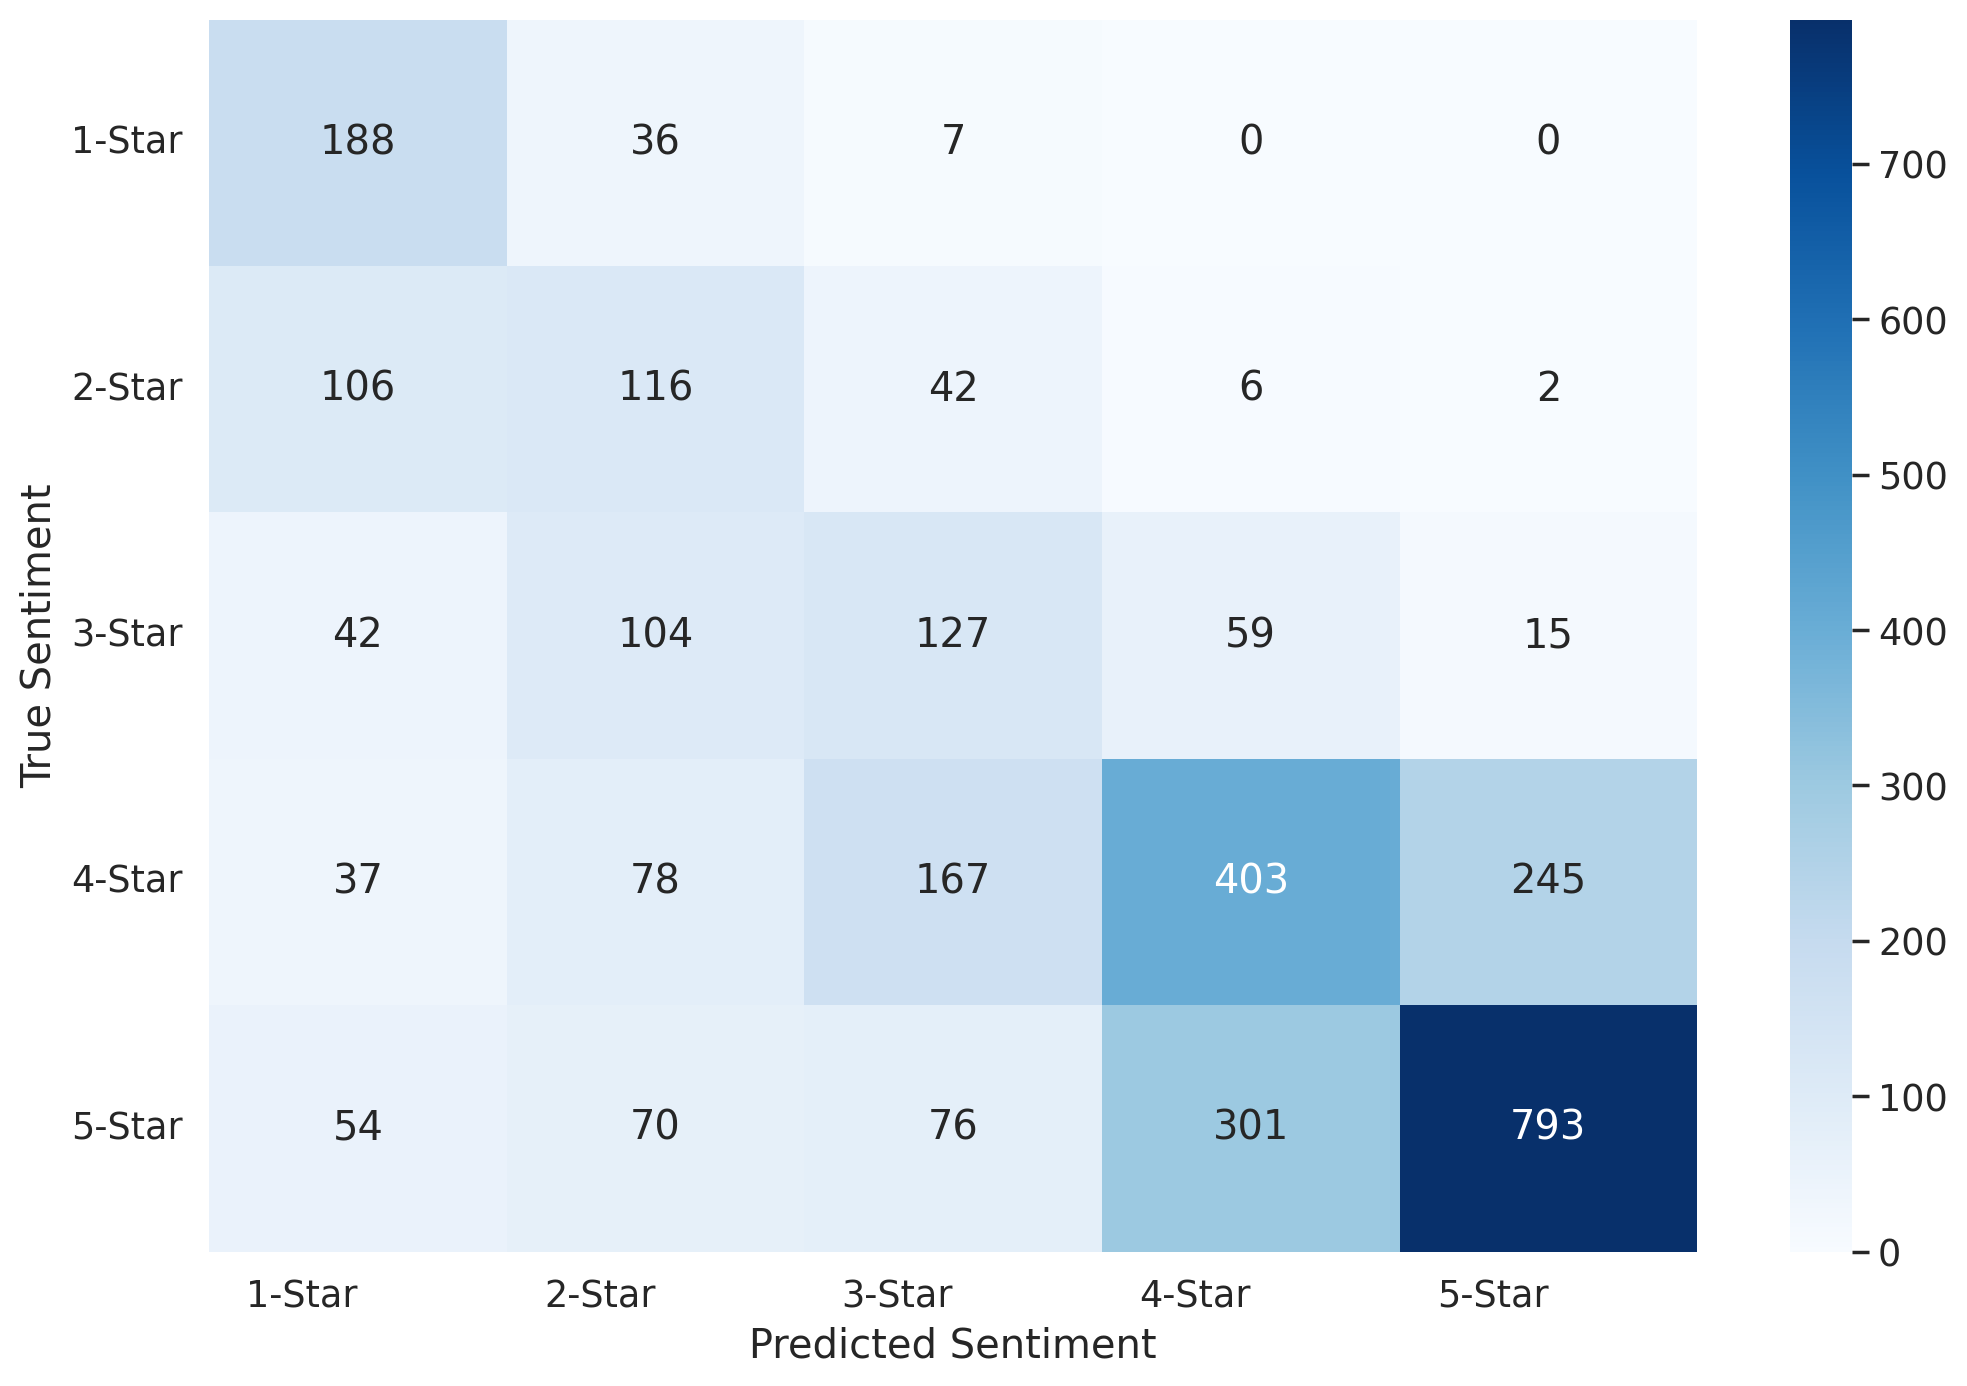

In [19]:
orig_cm = confusion_matrix(orig_real_values, orig_predictions)
df_orig_cm = pd.DataFrame(orig_cm, index=class_names, columns = class_names)
show_confusion_matrix(df_orig_cm)